# **Loading the Libraries**

In [44]:
import pandas as pd
import joblib

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Plots
import matplotlib.pyplot as plt
import seaborn as sns


# **Data Preproccesing**

In [14]:
df = pd.read_csv("/content/csic_database.csv", low_memory=False)

In [15]:
print("Dataset loaded:", df.shape)

Dataset loaded: (61065, 17)


In [16]:
print(df.columns.tolist())

['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'lenght', 'content', 'classification', 'URL']


In [17]:
print(df.head())


  Unnamed: 0 Method                                         User-Agent  \
0     Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
1     Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
2     Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
3     Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
4     Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   

     Pragma Cache-Control                                             Accept  \
0  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
1  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
2  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
3  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   
4  no-cache      no-cache  text/xml,application/xml,application/xhtml+xml...   

                    Accept-encoding               Accept-charset language 

In [18]:
if "URL" in df.columns and "content" in df.columns:
    df["request_text"] = df["URL"].astype(str) + " " + df["content"].astype(str)
    text_col = "request_text"
    print("Using merged text column:", text_col)
else:
    # fallback to your heuristic
    possible_text = ['content','path','uri','url','request','payload','body','params','query']
    text_col = next((c for c in possible_text if c in df.columns), None)

    if text_col is None:
        obj_cols = [c for c in df.columns if df[c].dtype == 'object']
        text_col = max(obj_cols, key=lambda c: df[c].astype(str).map(len).mean())

    print("Using text column:", text_col)


Using merged text column: request_text


In [19]:
possible_label_cols = ['label', 'classification', 'class', 'target', 'type']

for col in possible_label_cols:
    if col in df.columns:
        label_col = col
        break
else:
    raise SystemExit("No valid label column found. Please set label_col manually.")

print("Using label column:", label_col)
print(df[label_col].value_counts())


Using label column: classification
classification
0    36000
1    25065
Name: count, dtype: int64


**Data Cleaning**

In [20]:
columns_to_drop = [
    "Unnamed: 0",
    "User-Agent",
    "Pragma",
    "Cache-Control",
    "Accept",
    "Accept-encoding",
    "Accept-charset",
    "language",
    "host",
    "cookie",
    "content-type",
    "connection",
    "lenght"
]

In [21]:
df = df.drop(columns=columns_to_drop, errors="ignore")

In [22]:
print("New columns:", df.columns.tolist())

New columns: ['Method', 'content', 'classification', 'URL', 'request_text']


In [23]:
df.to_csv("csic_database_cleaned.csv", index=False)

In [24]:
df.head()

,Method,content,classification,URL,request_text
0,GET,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,http://localhost:8080/tienda1/index.jsp HTTP/1...
1,GET,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,http://localhost:8080/tienda1/publico/anadir.j...
2,POST,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,http://localhost:8080/tienda1/publico/anadir.j...
3,GET,NaN,0,http://localhost:8080/tienda1/publico/autentic...,http://localhost:8080/tienda1/publico/autentic...
4,POST,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,http://localhost:8080/tienda1/publico/autentic...


In [25]:
df.shape

(61065, 5)

# **Feature Engineering**

In [27]:
print(df['content'].isna().sum())

43088


In [28]:
df["request_text"] = df["URL"].astype(str) + " " + df["content"].astype(str)


In [29]:
df

,Method,content,classification,URL,request_text
0,GET,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,http://localhost:8080/tienda1/index.jsp HTTP/1...
1,GET,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,http://localhost:8080/tienda1/publico/anadir.j...
2,POST,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,http://localhost:8080/tienda1/publico/anadir.j...
3,GET,NaN,0,http://localhost:8080/tienda1/publico/autentic...,http://localhost:8080/tienda1/publico/autentic...
4,POST,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,http://localhost:8080/tienda1/publico/autentic...
...,...,...,...,...,...
61060,GET,NaN,1,http://localhost:8080/tienda1/miembros/editar....,http://localhost:8080/tienda1/miembros/editar....
61061,POST,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....,http://localhost:8080/tienda1/miembros/editar....
61062,GET,NaN,1,http://localhost:8080/tienda1/miembros/editar....,http://localhost:8080/tienda1/miembros/editar....
61063,GET,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...,http://localhost:8080/tienda1/imagenes/3.gif/ ...


In [30]:
df = df.rename(columns={"classification": "label"})


In [31]:
print(df["label"].value_counts())


label
0    36000
1    25065
Name: count, dtype: int64


In [32]:
X = df["request_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    analyzer="char",
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# **Model Training & Performance Metrics**

In [35]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM (LinearSVC)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        eval_metric="logloss",
        use_label_encoder=False
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1
    )
}

In [36]:
results = {}

In [37]:
for name, model in models.items():
    print(f"\n===============================\nTraining: {name}\n===============================")

    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, preds))

    results[name] = acc



Training: Logistic Regression
Accuracy: 0.9623
F1 Score: 0.9622
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7200
           1       0.96      0.95      0.95      5013

    accuracy                           0.96     12213
   macro avg       0.96      0.96      0.96     12213
weighted avg       0.96      0.96      0.96     12213


Training: SVM (LinearSVC)
Accuracy: 0.9771
F1 Score: 0.9770
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7200
           1       0.98      0.96      0.97      5013

    accuracy                           0.98     12213
   macro avg       0.98      0.98      0.98     12213
weighted avg       0.98      0.98      0.98     12213


Training: Random Forest
Accuracy: 0.9879
F1 Score: 0.9879
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7200
           1       0.99      0.98      0.99      501

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9877
F1 Score: 0.9877
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7200
           1       1.00      0.97      0.98      5013

    accuracy                           0.99     12213
   macro avg       0.99      0.99      0.99     12213
weighted avg       0.99      0.99      0.99     12213


Training: LightGBM
[LightGBM] [Info] Number of positive: 20052, number of negative: 28800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.723783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204651
[LightGBM] [Info] Number of data points in the train set: 48852, number of used features: 1582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410464 -> initscore=-0.362046
[LightGBM] [Info] Start training from score -0.362046


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9914
F1 Score: 0.9914
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7200
           1       1.00      0.98      0.99      5013

    accuracy                           0.99     12213
   macro avg       0.99      0.99      0.99     12213
weighted avg       0.99      0.99      0.99     12213



In [39]:
print("\n\n===== MODEL PERFORMANCE SUMMARY =====")
for m, a in results.items():
    print(f"{m:25} → {a:.4f}")

best_model = max(results, key=results.get)
print(f"\n Best Model = {best_model}")



===== MODEL PERFORMANCE SUMMARY =====
Logistic Regression       → 0.9623
SVM (LinearSVC)           → 0.9771
Random Forest             → 0.9879
XGBoost                   → 0.9877
LightGBM                  → 0.9914

 Best Model = LightGBM


# **Curves & Plotting**

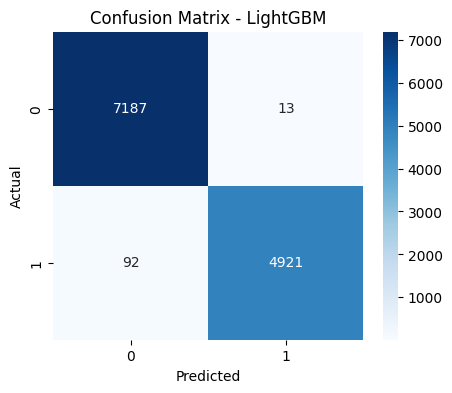

In [52]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [60]:

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Save best model
joblib.dump(models[best_model], "waf_best_model.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


Training Logistic Regression...
Logistic Regression AUC: 0.9936
Training SVM (LinearSVC)...
SVM (LinearSVC) AUC: 0.9961
Training Random Forest...
Random Forest AUC: 0.9973
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:42:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.9978
Training LightGBM...
[LightGBM] [Info] Number of positive: 20052, number of negative: 28800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.660005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204651
[LightGBM] [Info] Number of data points in the train set: 48852, number of used features: 1582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410464 -> initscore=-0.362046
[LightGBM] [Info] Start training from score -0.362046


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM AUC: 0.9981


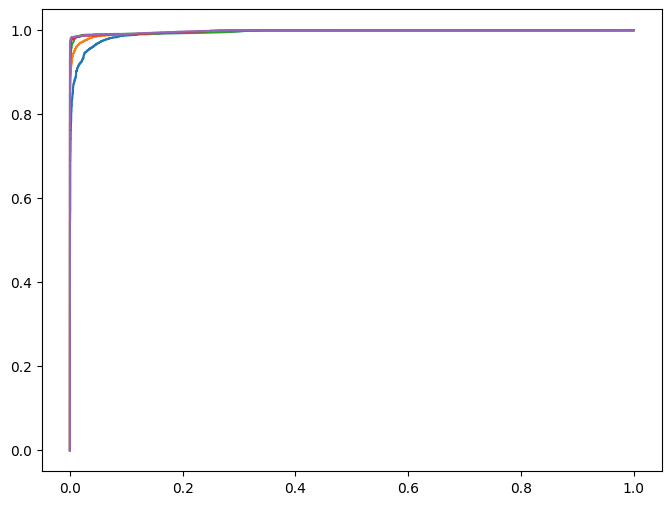

In [47]:
plt.figure(figsize=(8, 6))

# Generate ROC curves
for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train_vec, y_train)

    # Probability scores
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_vec)[:, 1]
    else:
        y_proba = model.decision_function(X_test_vec)

    # ROC-AUC Score
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} AUC: {auc:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

/tmp/ipython-input-3880616149.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


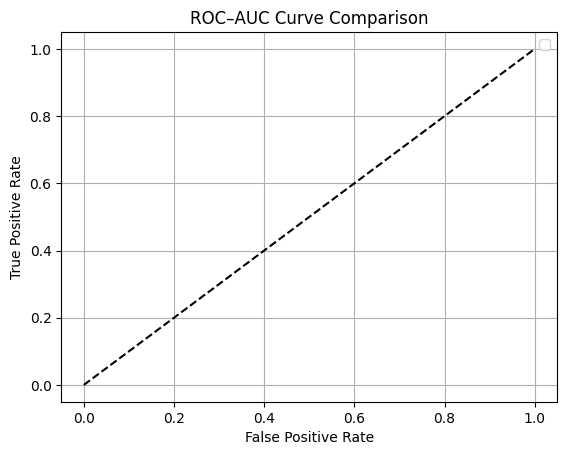

In [48]:
# Plot formatting
plt.plot([0, 1], [0, 1], "k--")  # diagonal line
plt.title("ROC–AUC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM ROC-AUC: 0.9981


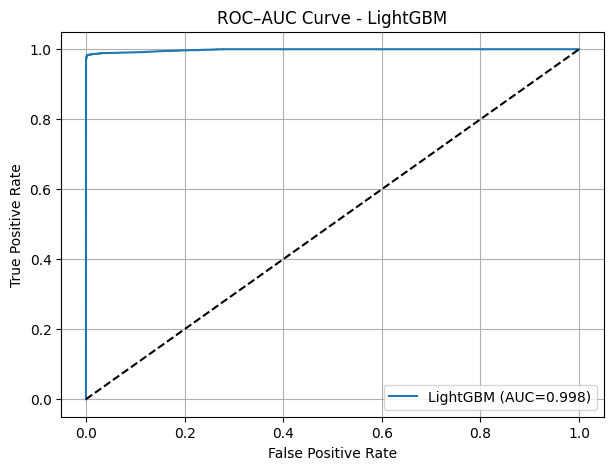

In [49]:
y_proba = model.predict_proba(X_test_vec)[:, 1]

# AUC Score
auc = roc_auc_score(y_test, y_proba)
print(f"LightGBM ROC-AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Plot ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"LightGBM (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")  # diagonal line
plt.title("ROC–AUC Curve - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
model.fit(
    X_train_vec, y_train,
    eval_set=[(X_test_vec, y_test)],
    eval_metric=["logloss", "error"]   # error = 1 - accuracy
)

[LightGBM] [Info] Number of positive: 20052, number of negative: 28800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.228518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204651
[LightGBM] [Info] Number of data points in the train set: 48852, number of used features: 1582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410464 -> initscore=-0.362046
[LightGBM] [Info] Start training from score -0.362046


LGBMClassifier(n_estimators=300)

In [54]:
# Extract eval results
results = model.evals_result_

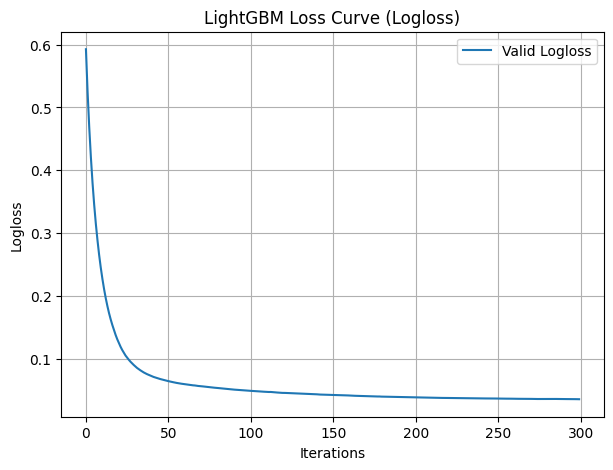

In [56]:
# LOSS CURVE (logloss)
plt.figure(figsize=(7, 5))
plt.plot(results["valid_0"]["binary_logloss"], label="Valid Logloss")
plt.title("LightGBM Loss Curve (Logloss)")
plt.xlabel("Iterations")
plt.ylabel("Logloss")
plt.grid(True)
plt.legend()
plt.show()

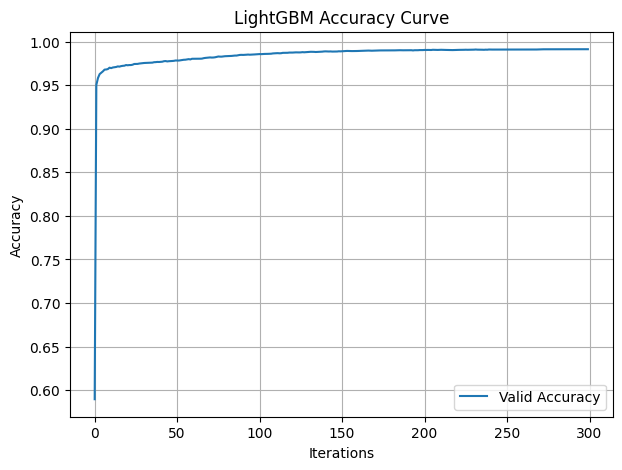

In [58]:

# ACCURACY CURVE (1 - error)
valid_error = results["valid_0"]["binary_error"]
valid_accuracy = [1 - x for x in valid_error]

plt.figure(figsize=(7, 5))
plt.plot(valid_accuracy, label="Valid Accuracy")
plt.title("LightGBM Accuracy Curve")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()